In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy import signal
import os
import pandas as pd
import spkit as sp



In [3]:

with open('/Users/laura/Documents/MUSE/The_Village_Domenico_Abdullah/MuseB_20250414_134606_trial_1A/EEG/merged_data.json', 'r') as f:
    eeg_data = json.load(f)

In [5]:
print(eeg_data[0])

{'seq': 0, 'starting_timestamp': 1744631174961061000, 'data': [[-33.69140625, -26.3671875, -28.3203125, -44.43359375, -48.33984375, -34.1796875, -43.45703125, -62.5, -63.4765625, -61.5234375, -43.9453125, -41.50390625, -38.57421875, -32.71484375, -39.55078125, -36.1328125, -30.76171875, -28.3203125, -30.2734375, -38.57421875], [-31.25, -31.73828125, -30.76171875, -33.203125, -32.2265625, -33.69140625, -34.1796875, -39.0625, -44.43359375, -46.875, -49.31640625, -40.52734375, -31.25, -24.90234375, -20.5078125, -17.578125, -10.7421875, -11.23046875, -19.53125, -26.85546875], [-30.76171875, -30.2734375, -25.87890625, -24.90234375, -26.3671875, -24.4140625, -18.06640625, -20.01953125, -28.3203125, -29.78515625, -27.34375, -35.15625, -40.52734375, -39.0625, -43.9453125, -42.96875, -37.59765625, -37.109375, -36.62109375, -40.0390625], [-28.3203125, -40.0390625, -17.578125, -16.6015625, -32.71484375, -32.2265625, -27.34375, -36.1328125, -45.41015625, -56.640625, -53.22265625, -58.10546875, -72

In [7]:

eeg_data_matrix = np.array(eeg_data[0]['data'])

print(eeg_data_matrix.shape)


(4, 20)


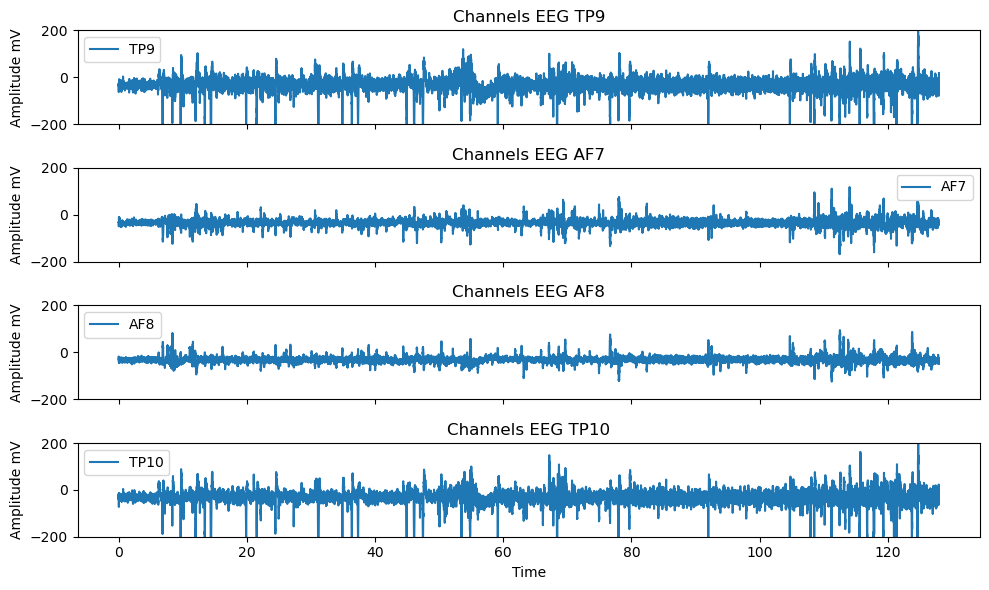

In [9]:

concatenated_data = []
for seq in eeg_data:
    concatenated_data.append(seq['data'])

concatenated_data = np.concatenate([np.array(seq_data) for seq_data in concatenated_data], axis=1)

sampling_rate = 256  # Hz
time_points = np.arange(concatenated_data.shape[1]) / sampling_rate  

channel_names = ['TP9', 'AF7', 'AF8', 'TP10']

fig, axes = plt.subplots(concatenated_data.shape[0], 1, figsize=(10, 6), sharex=True)
if concatenated_data.shape[0] == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(time_points, concatenated_data[i, :], label=f'{channel_names[i]}')
    ax.set_title(f"Channels EEG {channel_names[i]}")
    ax.set_ylabel("Amplitude mV")
    ax.legend()
    ax.set_ylim(-200, 200)

# Agregar etiquetas y título común
plt.xlabel("Time")
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:507: UserWarning: Make sure the upper and lower bound values (k1,k2) are of same order as signal amplitude. If amplitude of signal is much lower than k2 or even k1, ATAR algorithm will have no affect on signal. For example, k2=100, and/or k1=10 is setting for amplitude in micro-volt (in order of 100s). If provided signal is in volt (1e-6), multiply signal with 1e6 (X*1e6) and then apply ATAR
/opt/anaconda3/lib/python3.12/site-packages/spkit/eeg/atar_algorithm.py:510: UserWarning: Upper bound k2 is set to very high. ATAR might have no impact of signal. Either change amplitude unit of signal by multiplying 1e3, or 1e6, or lower the value of k2 and respectively, k1.  One of the straightforward way to set k2 is k2 = np.std(X).


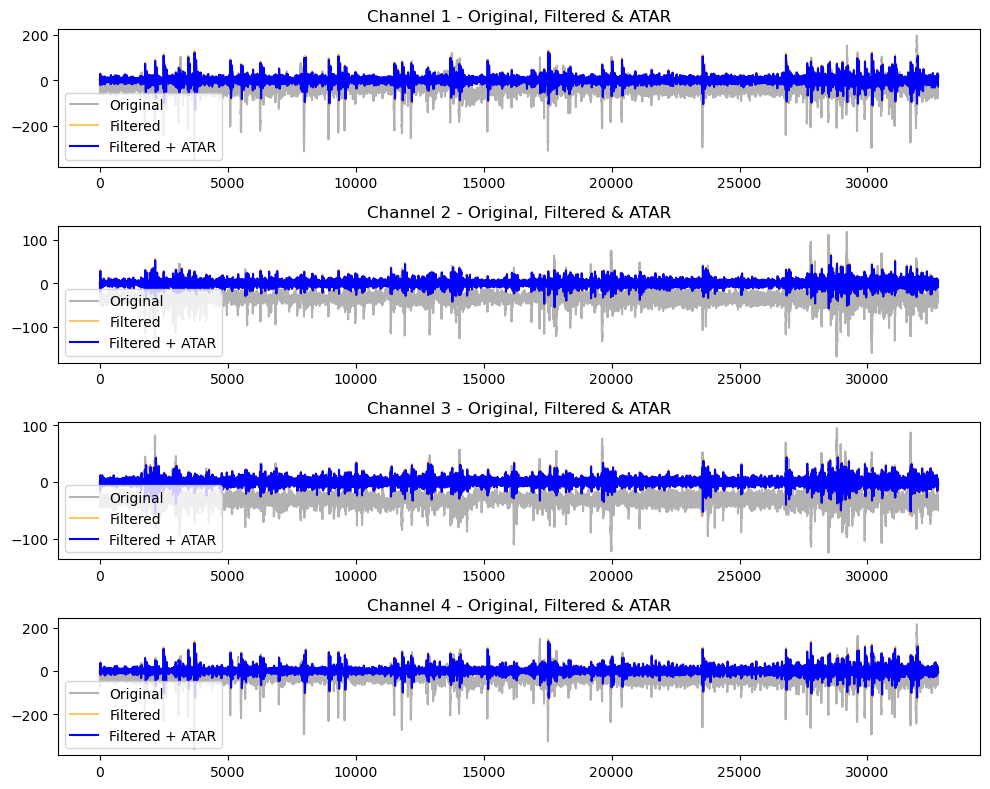

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import spkit as sp

# Define filtering functions
def filtering(data, samp_freq):
    # Notch filter (50Hz)
    notch_freq = 50.0
    quality_factor = 3.0
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
    
    # Bandpass filter (3-40 Hz)
    sos = signal.butter(5, [3, 40], 'bandpass', fs=samp_freq, output='sos')
    
    # Apply filters to each channel
    data_notched = np.copy(data)
    data_notched_fil = np.copy(data)
    
    # Apply notch filter and then bandpass filter
    for ii in range(data.shape[0]):  # loop over channels
        data_notched[ii, :] = signal.filtfilt(b_notch, a_notch, data[ii, :])  # Notch filter
        data_notched_fil[ii, :] = signal.sosfilt(sos, data_notched[ii, :])  # Bandpass filter

    return data_notched_fil

# Apply ATAR artifact removal for all channels
def apply_atar(data, samp_freq):
    data_ar = np.copy(data)
    
    # Apply ATAR method (replace with your ATAR method implementation)
    # Here, I'm assuming you have the normal ATAR function for all channels
    data_ar = sp.eeg.ATAR(data.copy(), wv='db4', winsize=5 * samp_freq, beta=0.9, 
                          thr_method='ipr', OptMode='elim', verbose=0)
    
    return data_ar

# Set parameters
sampling_rate = 256  # Hz
time_points = np.arange(concatenated_data.shape[1]) / sampling_rate  # Time points

# Apply filtering and ATAR
filtered_data = filtering(concatenated_data, sampling_rate)
filtered_data_ar = apply_atar(filtered_data, sampling_rate)

# Plot the original, filtered, and ATAR-filtered data
def plot_filtered_and_atar_data(original_data, filtered_data, filtered_data_ar, channels=4):
    fig, axes = plt.subplots(channels, 1, figsize=(10, 8))
    time = np.arange(original_data.shape[1])  # Time points

    for i in range(channels):
        # Plot original data
        axes[i].plot(time, original_data[i], label="Original", color='gray', alpha=0.6)
        
        # Plot filtered data
        axes[i].plot(time, filtered_data[i], label="Filtered", color='orange', alpha=0.6)
        
        # Plot filtered + ATAR data
        axes[i].plot(time, filtered_data_ar[i], label="Filtered + ATAR", color='blue')

        axes[i].set_title(f"Channel {i+1} - Original, Filtered & ATAR")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function to visualize original, filtered, and filtered + ATAR data
plot_filtered_and_atar_data(concatenated_data, filtered_data, filtered_data_ar)



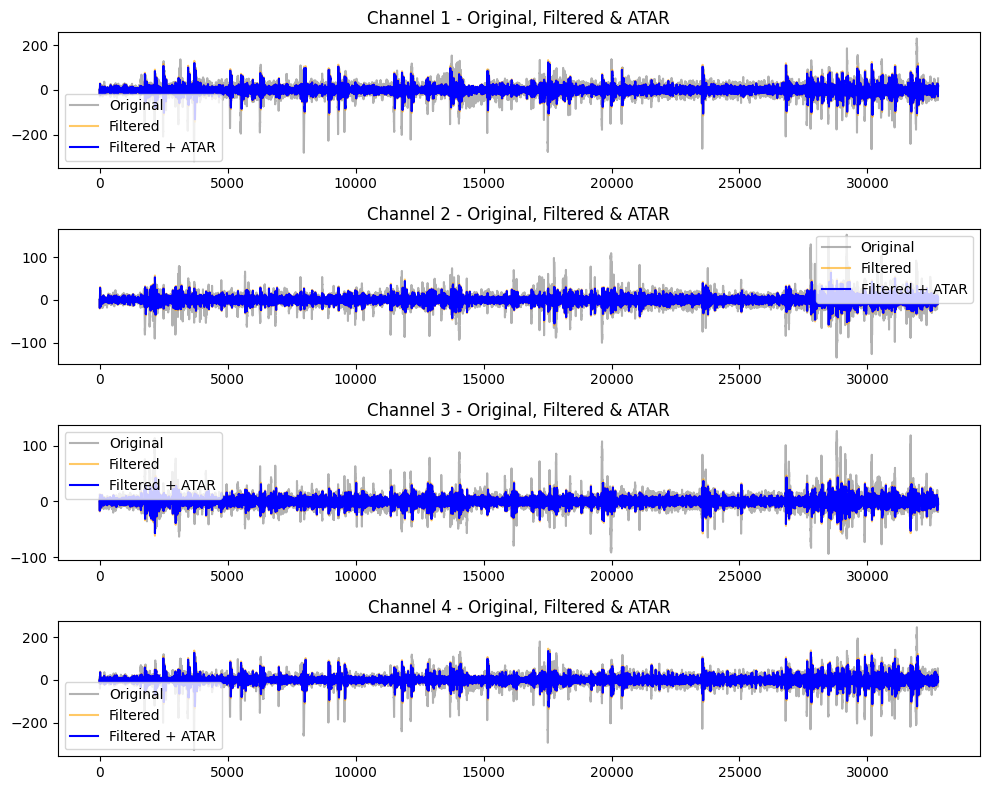

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pywt
import spkit as sp

# Define filtering functions
def filtering(data, samp_freq):
    # Notch filter (50Hz)
    notch_freq = 50.0
    quality_factor = 3.0
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, samp_freq)
    
    # Bandpass filter (3-40 Hz)
    sos = signal.butter(5, [3, 40], 'bandpass', fs=samp_freq, output='sos')
    
    # Apply filters to each channel
    data_notched = np.copy(data)
    data_notched_fil = np.copy(data)
    
    # Apply notch filter and then bandpass filter
    for ii in range(data.shape[0]):  # loop over channels
        data_notched[ii, :] = signal.filtfilt(b_notch, a_notch, data[ii, :])  # Notch filter
        data_notched_fil[ii, :] = signal.sosfilt(sos, data_notched[ii, :])  # Bandpass filter

    return data_notched_fil

# Apply ATAR artifact removal for all channels
def apply_atar(data, samp_freq):
    data_ar = np.copy(data)
    
    # Apply ATAR method (replace with your ATAR method implementation)
    # Here, I'm assuming you have the normal ATAR function for all channels
    data_ar = sp.eeg.ATAR(data.copy(), wv='db4', winsize=5 * samp_freq, beta=0.9, 
                          thr_method='ipr', OptMode='elim', verbose=0)
    
    return data_ar

# Normalize data by subtracting the mean (to center the data)
def normalize_data(data):
    return data - np.mean(data, axis=1, keepdims=True)

# Set parameters
sampling_rate = 256  # Hz
time_points = np.arange(concatenated_data.shape[1]) / sampling_rate  # Time points

# Apply filtering and ATAR
filtered_data = filtering(concatenated_data, sampling_rate)
filtered_data_ar = apply_atar(filtered_data, sampling_rate)

# Normalize all signals (original, filtered, and ATAR-filtered)
normalized_original = normalize_data(concatenated_data)
normalized_filtered = normalize_data(filtered_data)
normalized_filtered_ar = normalize_data(filtered_data_ar)

# Plot the original, filtered, and ATAR-filtered data
def plot_filtered_and_atar_data(original_data, filtered_data, filtered_data_ar, channels=4):
    fig, axes = plt.subplots(channels, 1, figsize=(10, 8))
    time = np.arange(original_data.shape[1])  # Time points

    for i in range(channels):
        # Plot original data
        axes[i].plot(time, original_data[i], label="Original", color='gray', alpha=0.6)
        
        # Plot filtered data
        axes[i].plot(time, filtered_data[i], label="Filtered", color='orange', alpha=0.6)
        
        # Plot filtered + ATAR data
        axes[i].plot(time, filtered_data_ar[i], label="Filtered + ATAR", color='blue')

        axes[i].set_title(f"Channel {i+1} - Original, Filtered & ATAR")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function to visualize original, filtered, and filtered + ATAR data
plot_filtered_and_atar_data(normalized_original, normalized_filtered, normalized_filtered_ar)


In [33]:
df=pd.read_csv('/Users/laura/Documents/MUSE/HOLS/S002R04_125Hz_raw.csv')

In [34]:
df.shape

(23, 14967)

In [31]:
from brainflow.board_shim import BoardShim, BoardIds

# Obtener descripción del Cyton Daisy Board
board_description = BoardShim.get_board_descr(BoardIds.CYTON_BOARD)
print(board_description)

{'accel_channels': [9, 10, 11], 'analog_channels': [19, 20, 21], 'ecg_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'eeg_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'eeg_names': 'Fp1,Fp2,C3,C4,P7,P8,O1,O2', 'emg_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'eog_channels': [1, 2, 3, 4, 5, 6, 7, 8], 'marker_channel': 23, 'name': 'Cyton', 'num_rows': 24, 'other_channels': [12, 13, 14, 15, 16, 17, 18], 'package_num_channel': 0, 'sampling_rate': 250, 'timestamp_channel': 22}


In [35]:
# Extraer los canales de EEG
eeg_channels = df.iloc[[0, 1, 2, 3, 4, 5, 6, 7], :].to_numpy()

# Extraer los canales de ECG (de manera similar)
ecg_channels = df.iloc[[1, 2, 3, 4, 5, 6, 7, 8], :].to_numpy()

# Extraer los canales de acelerómetro
accel_channels = df.iloc[[9, 10, 11], :].to_numpy()

# Extraer los otros canales
other_channels = df.iloc[[12, 13, 14, 15, 16, 17, 18], :].to_numpy()

# Canal de marcador (canal 23)
marker_channel = df.iloc[22, :].to_numpy()

# Canal de tiempo (canal 22)
timestamp_channel = df.iloc[21, :].to_numpy()

# Comprobar las dimensiones
print(f"EEG shape: {eeg_channels.shape}")
print(f"ECG shape: {ecg_channels.shape}")
print(f"Acelerómetro shape: {accel_channels.shape}")


EEG shape: (8, 14967)
ECG shape: (8, 14967)
Acelerómetro shape: (3, 14967)
